In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-66e224d4-a0ad-8dec-9b44-2f0f48465b40)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR 
from torchvision.transforms.transforms import ToPILImage
from PIL import Image
import cv2
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Dataset

In [5]:
class FACE_IMG(Dataset):
  def __init__(self, dataset_path, _type, transform=None):
    self.transform = transform
    self.dataset_path = dataset_path
    self.images_path = []
    self.images_labels = []
    for idx_folder, folder in enumerate(os.listdir(self.dataset_path)):
      number_of_images_in_this_folder = len([_ for _ in os.listdir(os.path.join(self.dataset_path, folder))])
      for idx, filename in enumerate(os.listdir(os.path.join(self.dataset_path, folder))):
        if _type == 'Train' and idx in range(int(number_of_images_in_this_folder * 0.8)):
          self.images_path.append(os.path.join(self.dataset_path, folder, filename))
          self.images_labels.append(idx_folder)
        elif _type == 'Test'and idx in range(int(number_of_images_in_this_folder * 0.8), number_of_images_in_this_folder):
          self.images_path.append(os.path.join(self.dataset_path, folder, filename))
          self.images_labels.append(idx_folder)

  def __len__(self):
    return len(self.images_path)

  def __getitem__(self, index):
    img = cv2.imread(self.images_path[index])
    label = self.images_labels[index]
    if self.transform:
      image = self.transform(img)
    one_hot_label = np.zeros(7)
    one_hot_label[label] = 1
    return image, torch.from_numpy(one_hot_label)


In [6]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),  
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
path = "/content/drive/MyDrive/CK+48"

In [7]:
ds = FACE_IMG(path, 'Test', preprocess)

In [8]:
ds[10][1]

tensor([1., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

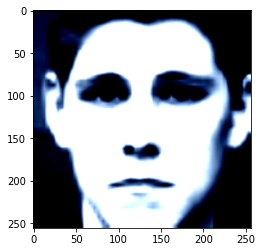

In [9]:
plt.imshow(ds[10][0].numpy().transpose([1,2,0]))

In [10]:
# 80% train, 20% test
BATCH_SIZE = 16
trainloader = torch.utils.data.DataLoader(FACE_IMG(path, 'Train', preprocess), batch_size=BATCH_SIZE,   
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(FACE_IMG(path, 'Test', preprocess), batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Model

In [11]:
import torchvision.models as models

face_net = models.vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [12]:
face_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
class FaceNet2ExpNet(nn.Module):
  def __init__(self):
    super(FaceNet2ExpNet, self).__init__()
        
    features = list(face_net.features)
    self.face_net = nn.ModuleList(features)  
    for param in self.face_net.parameters(): #freeze face net parameters
      param.requires_grad = False
    
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1 , padding=3)
    self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1 , padding=3)
    self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1 , padding=3)
    self.max_pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1 , padding=3)
    self.max_pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
    self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1 , padding=3)
    self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

    #self.last_conv = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=3 , padding=6)
    self.last_conv = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=1)
    #self.last_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0) #????????????????

    self.FC = nn.Linear(in_features=32768, out_features=7)

  def stage1_forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = F.relu(self.conv3(x))
    x = self.max_pool3(x)
    x = F.relu(self.conv4(x))
    x = self.max_pool4(x)
    x = F.relu(self.conv5(x))
    x = self.max_pool5(x)

    x = self.last_conv(x)
    return x
  
  def faceNet_forward(self, x):
    for i,layer in enumerate(self.face_net):
      x = layer(x)
    return x

  def stage2_forward(self, x):
    x = self.stage1_forward(x)
    #x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.FC(x)
    return x
  

In [14]:
model = FaceNet2ExpNet().to(device)

In [15]:
def save_ckp(state, checkpoint_path): 
  f_path = checkpoint_path 
  # save checkpoint data to the path given, checkpoint_path 
  torch.save(state, f_path)

In [16]:
def stage1_train(model, epochs, trainloader, testloader, save_path):
  loss_train = []
  loss_test = []
  optimizer = optim.SGD(model.parameters(), lr = 5e-1, momentum = 0.9)
  model.stage1_lr = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
  loss_function = nn.MSELoss()

  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      img, label = data[0].to(device), data[1]
      optimizer.zero_grad()
      output = model.stage1_forward(img)
      faceNet_output = model.faceNet_forward(img)
      loss = loss_function(output, faceNet_output)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    
    #######################################################
    loss_train.append(running_loss / (i+1))
    print('[%d] loss Train: %.8f' % (epoch + 1, loss_train[-1]))
    ################################## Test #################################
    if epoch % 5 == 4:
      with torch.no_grad():
        running_loss_test = 0.0
        for j, data_test in enumerate(testloader, 0):
          img, label = data_test[0].to(device), data_test[1]
          output = model.stage1_forward(img)
          faceNet_output = model.faceNet_forward(img)
          loss = loss_function(output, faceNet_output)
          running_loss_test += loss.item()
        loss_test.append(running_loss_test / (j+1))
        print('-------------------------------[%d] loss Test: %.8f' % (epoch + 1, loss_test[-1]))

      checkpoint = {'epoch': epoch + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()} 
      save_ckp(checkpoint, save_path)

  return loss_train, loss_test


In [17]:
def plot_stage1_results(loss_train, loss_test):
  plt.plot(np.arange(1,len(loss_train)+1), loss_train)
  plt.ylabel('loss of Train')
  plt.xlabel("epochs")
  plt.grid(True)
  plt.show()

  plt.plot(np.arange(1,len(loss_test)+1), loss_test)
  plt.ylabel('loss of Test')
  plt.xlabel("each 5 epochs")
  plt.grid(True)
  plt.show()

In [19]:
save_path = '/content/drive/MyDrive/DL_Final_Project/model.pt'
loss_train, loss_test = stage1_train(model, 100, trainloader, testloader, save_path)

[1] loss Train: 0.23534162
[2] loss Train: 0.22689872
[3] loss Train: 0.22040371
[4] loss Train: 0.21518867
[5] loss Train: 0.21011195
-------------------------------[5] loss Test: 0.20810314
[6] loss Train: 0.20431937
[7] loss Train: 0.20002184
[8] loss Train: 0.19652487
[9] loss Train: 0.19177687
[10] loss Train: 0.18823559
-------------------------------[10] loss Test: 0.19398319
[11] loss Train: 0.18521739
[12] loss Train: 0.18308023
[13] loss Train: 0.17967290
[14] loss Train: 0.17680636
[15] loss Train: 0.17366484
-------------------------------[15] loss Test: 0.18266504
[16] loss Train: 0.17025745
[17] loss Train: 0.16798077
[18] loss Train: 0.16548323
[19] loss Train: 0.16388055
[20] loss Train: 0.15986003
-------------------------------[20] loss Test: 0.17349655
[21] loss Train: 0.15860692
[22] loss Train: 0.15721322
[23] loss Train: 0.15406967
[24] loss Train: 0.15204679
[25] loss Train: 0.14894749
-------------------------------[25] loss Test: 0.16639240
[26] loss Train: 0.1

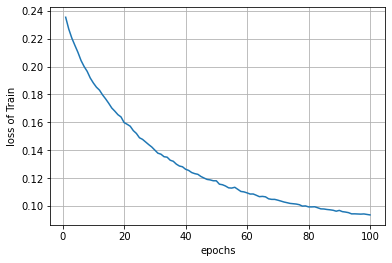

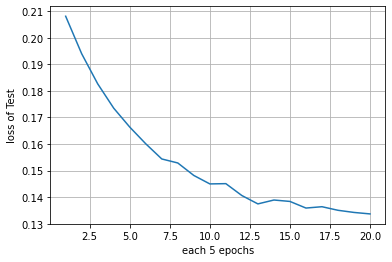

In [20]:
plot_stage1_results(loss_train, loss_test)

In [21]:
def stage2_train(self, epochs, trainloader, testloader):
  loss_train = []
  loss_test = []
  acc_test = []

  y_pred = []
  y_true = []

  optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9)
  loss_function = nn.CrossEntropyLoss()

  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      img, label = data[0].to(device), data[1].to(device)
      optimizer.zero_grad()
      output = self.stage2_forward(img)
      loss = loss_function(output, label)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    #######################################################
    loss_train.append(running_loss / (i+1))
    print('[%d] loss Train: %.8f' % (epoch + 1, loss_train[-1]))
    ################################## Test #################################
    
    with torch.no_grad():
      running_loss_test = 0.0
      running_acc = 0.0
  
      for j, data_test in enumerate(testloader, 0):
        img, label = data_test[0].to(device), data_test[1].to(device)
        output = self.stage2_forward(img)

        y_pred.extend(torch.argmax(output, 1).cpu().numpy())
        y_true.extend(torch.argmax(label, 1).cpu().numpy())
        
        loss = loss_function(output, label)
        running_acc += accuracy_score(torch.argmax(label, 1).cpu().numpy(), torch.argmax(output, 1).cpu().numpy())
        running_loss_test += loss.item()
      acc_test.append(running_acc / (j+1))
      loss_test.append(running_loss_test / (j+1))
      print('----------------------[%d] loss Test: %.8f , Accuracy: %.4f' % (epoch + 1, loss_test[-1], acc_test[-1]))
    
    if epoch % 3 == 2:
      checkpoint = {'epoch': epoch + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()} 
      save_ckp(checkpoint, save_path)

  return loss_train, loss_test, acc_test, y_pred, y_true


In [22]:
def plot_stage2_results(loss_train, loss_test, acc_test):
  plt.plot(np.arange(1,len(loss_train)+1), loss_train)
  plt.ylabel('loss of Train')
  plt.xlabel("epochs")
  plt.grid(True)
  plt.show()

  plt.plot(np.arange(1,len(loss_test)+1), loss_test)
  plt.ylabel('loss of Test')
  plt.xlabel("epochs")
  plt.grid(True)
  plt.show()

  plt.plot(np.arange(1,len(acc_test)+1), acc_test)
  plt.ylabel('Accuracy of Test')
  plt.xlabel("epochs")
  plt.grid(True)
  plt.show()

In [23]:
def plot_confusion_matrix(y_pred, y_true):

  classes = ('anger', 'contempt', 'disgust', 'fear', 'happy','sadness', 'surprise')

  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *7, index = [i for i in classes],columns = [i for i in classes])
  
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)

In [24]:
stage2_loss_train, stage2_loss_test, acc_test, y_pred, y_true= stage2_train(model, 15, trainloader, testloader)

[1] loss Train: 0.58402329
----------------------[1] loss Test: 0.37731160 , Accuracy: 0.8846
[2] loss Train: 0.06183964
----------------------[2] loss Test: 0.25875840 , Accuracy: 0.9519
[3] loss Train: 0.01240665
----------------------[3] loss Test: 0.21937321 , Accuracy: 0.9663
[4] loss Train: 0.01104227
----------------------[4] loss Test: 0.22940245 , Accuracy: 0.9615
[5] loss Train: 0.00700919
----------------------[5] loss Test: 0.31213874 , Accuracy: 0.9631
[6] loss Train: 0.00234395
----------------------[6] loss Test: 0.32452016 , Accuracy: 0.9631
[7] loss Train: 0.00198900
----------------------[7] loss Test: 0.23131425 , Accuracy: 0.9631
[8] loss Train: 0.00162309
----------------------[8] loss Test: 0.22408812 , Accuracy: 0.9712
[9] loss Train: 0.00143566
----------------------[9] loss Test: 0.22429371 , Accuracy: 0.9712
[10] loss Train: 0.00121198
----------------------[10] loss Test: 0.22363051 , Accuracy: 0.9712
[11] loss Train: 0.00112742
----------------------[11] los

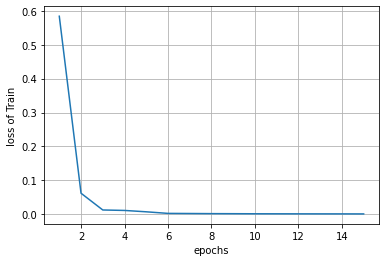

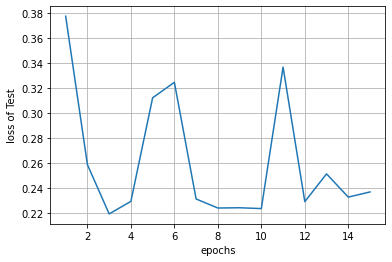

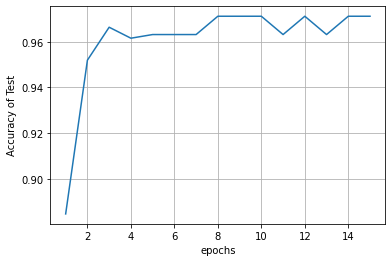

In [25]:
plot_stage2_results(stage2_loss_train, stage2_loss_test, acc_test)

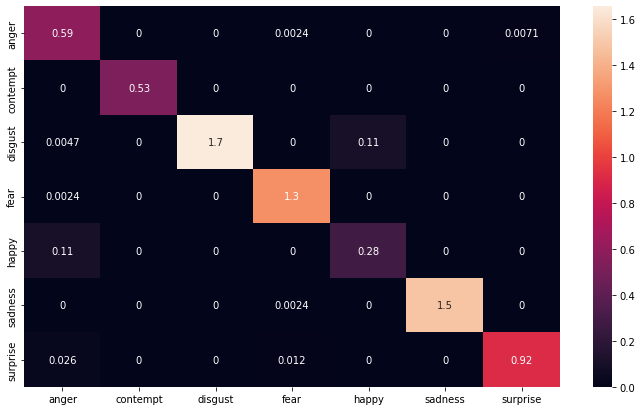

In [26]:
plot_confusion_matrix(y_pred, y_true)